In [1]:
import sys
import os
import json
sys.path.append("../utils")
sys.path.append("../")
import tensorflow as tf
from utils.llutils import *
from ltv_utils import *
pd.set_option('display.float_format', '{:.4f}'.format)  # 保留10位小数，可调整
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)


2025-05-20 22:36:39.264184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-20 22:36:39.430488: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 22:36:39.436006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-20 22:36:39.436025: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
df = load_obj("ad_install_ltv_sequence_feature.obj")
df = df[df.dt <= '2025-05-10']

In [4]:
promo_dates = [

    {"date": "2022-02-01", "festival": "春节"},
    {"date": "2022-02-14", "festival": "情人节"},
    {"date": "2022-03-08", "festival": "女王节"},
    {"date": "2022-05-20", "festival": "520表白节"},
    {"date": "2022-06-18", "festival": "618年中大促"},
    {"date": "2022-08-04", "festival": "七夕节"},
    {"date": "2022-09-10", "festival": "中秋节"},
    {"date": "2022-10-01", "festival": "国庆大促"},
    {"date": "2022-11-11", "festival": "双11"},
    {"date": "2022-12-12", "festival": "双12"},
    {"date": "2022-12-25", "festival": "圣诞节"},

    {"date": "2023-01-22", "festival": "春节"},
    {"date": "2023-02-14", "festival": "情人节"},
    {"date": "2023-03-08", "festival": "女王节"},

    {"date": "2023-05-20", "festival": "520表白节"},
    {"date": "2023-06-18", "festival": "618年中大促"},
    {"date": "2023-08-22", "festival": "七夕节"},
    {"date": "2023-09-29", "festival": "中秋节"},
    {"date": "2023-10-01", "festival": "国庆大促"},
    {"date": "2023-11-11", "festival": "双11"},
    {"date": "2023-12-12", "festival": "双12"},
    {"date": "2023-12-25", "festival": "圣诞节"},

    {"date": "2024-02-10", "festival": "春节"},
    {"date": "2024-02-14", "festival": "情人节"},
    {"date": "2024-03-08", "festival": "女王节"},

    {"date": "2024-05-20", "festival": "520表白节"},
    {"date": "2024-06-18", "festival": "618年中大促"},
    {"date": "2024-08-10", "festival": "七夕节"},
    {"date": "2024-09-17", "festival": "中秋节"},
    {"date": "2024-10-01", "festival": "国庆大促"},
    {"date": "2024-11-11", "festival": "双11"},
    {"date": "2024-12-12", "festival": "双12"},
    {"date": "2024-12-25", "festival": "圣诞节"},

    {"date": "2025-01-29", "festival": "春节"},
    {"date": "2025-02-14", "festival": "情人节"},
    {"date": "2025-03-08", "festival": "女王节"},
    {"date": "2025-05-20", "festival": "520表白节"},
    {"date": "2025-06-18", "festival": "618年中大促"},
    {"date": "2025-07-29", "festival": "七夕节"},
    {"date": "2025-10-06", "festival": "中秋节"},
    {"date": "2025-10-01", "festival": "国庆大促"},
    {"date": "2025-11-11", "festival": "双11"},
    {"date": "2025-12-12", "festival": "双12"},
    {"date": "2025-12-25", "festival": "圣诞节"},
]

In [5]:
promo_dates =[ pdate['date'] for pdate in promo_dates if pdate['festival'] in  ('618年中大促', '双11','双12', '圣诞节')]
holiday_dates = [
    '2022-01-01','2022-02-01',  '2022-05-01', '2022-06-03', '2022-09-10', '2022-10-01', '2022-10-04', '2022-01-31',
    '2023-01-01', '2023-01-22',  '2023-05-01', '2023-06-22', '2023-09-29', '2023-10-01', '2023-10-23', '2023-01-21',
    '2024-01-01','2024-02-10',  '2024-05-01', '2024-06-10', '2024-09-17', '2024-10-01', '2024-10-02', '2024-02-09',
    '2025-01-01','2025-01-29',  '2025-05-01', '2025-06-20', '2025-10-06', '2025-10-01', '2025-09-30', '2025-01-28'
]

In [6]:
def days_to_next_promo(current_date):
    future_promos = [p for p in list(promo_set) + list(holiday_set) if p >= current_date.date()]
    if not future_promos:
        return 0
    nearest = min(future_promos)
    delta = (nearest - current_date.date()).days
    return delta if delta <= 10 else 0

def days_past_last_promo(current_date):
    future_promos = [p for p in list(promo_set) + list(holiday_set) if p < current_date.date()]
    if not future_promos:
        return 0
        
    nearest = max(future_promos)
    delta = (current_date.date() - nearest).days
    return delta if delta <= 10 else 0

In [7]:
df['dt'] = pd.to_datetime(df['dt'])
# 提取日期相关特征
df['month'] = df['dt'].dt.month
df['weekday'] = df['dt'].dt.weekday  # 周一=0,...周日=6
# 标记节假日和大促日
holiday_set = set(pd.to_datetime(holiday_dates).date)
promo_set = set(pd.to_datetime(list(promo_dates)).date)
df['is_holiday'] = df['dt'].dt.date.apply(lambda x: 1 if x in holiday_set else 0)
df['is_promo'] = df['dt'].dt.date.apply(lambda x: 1 if x in promo_set else 0)

    
df['days_to_next_promo'] = df['dt'].apply(days_to_next_promo)
df['days_past_last_promo'] = df['dt'].apply(days_past_last_promo)
# 设定季节
def get_season(month):
    if month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    elif month in [9,10,11]:
        return 'autumn'
    else:
        return 'winter'
df['season'] = df['month'].apply(get_season)


In [8]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设 df 是原始数据 DataFrame
categorical_features = ['month', 'weekday', 'is_holiday', 'is_promo', 'season']
dense_features = ['install_deviceid_cnt', 'day1_ltv_sum', 'days_to_next_promo', 'days_past_last_promo']
target = 'day7_ltv_sum'

# 处理类别特征，将它们转换为整数索引
df['month'] = df['month'].astype('category').cat.codes
df['weekday'] = df['weekday'].astype('category').cat.codes
df['is_holiday'] = df['is_holiday'].astype('category').cat.codes
df['is_promo'] = df['is_promo'].astype('category').cat.codes
df['season'] = df['season'].astype('category').cat.codes

# 特征选择
X = df[categorical_features + dense_features].values
y = df[target].values


# 计算各数据集大小
total_size = len(df)
train_size = int(total_size * 0.8)  # 80%作为训练+验证集
test_size = total_size - train_size


import numpy as np
from sklearn.preprocessing import StandardScaler

# 特征选择
X = df[categorical_features + dense_features].values
y = df[target].values

# 计算各数据集大小
total_size = len(df)
train_size = int(total_size * 0.8)  # 80%作为训练+验证集
test_size = total_size - train_size

# 划分测试集
X_train_valid = X[:train_size]
X_test = X[train_size:]
y_train_valid = y[:train_size]
y_test = y[train_size:]

# 对dense特征进行标准化
dense_feat_indices = [i for i, feat in enumerate(categorical_features + dense_features) if feat in dense_features]
scaler_X = StandardScaler()
X_train_valid[:, dense_feat_indices] = scaler_X.fit_transform(X_train_valid[:, dense_feat_indices])
X_test[:, dense_feat_indices] = scaler_X.transform(X_test[:, dense_feat_indices])

# 对y进行标准化
scaler_y = StandardScaler()
y_train_valid_scaled = scaler_y.fit_transform(y_train_valid.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# 从训练集中划分验证集(15%)
valid_size = int(train_size * 0.15)
X_train = X_train_valid[:-valid_size]
X_valid = X_train_valid[-valid_size:]
y_train_scaled = y_train_valid_scaled[:-valid_size]
y_valid_scaled = y_train_valid_scaled[-valid_size:]



In [ ]:
y_test_base = 

In [21]:
X_valid_categorical_tensor.shape, X_valid_dense_tensor.shape

(torch.Size([147, 5]), torch.Size([147, 4]))

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, out_dim)
        self.linear_res = nn.Linear(in_dim, out_dim)  # Skip connection
        self.dropout = nn.Dropout(0.2)
        self.layernorm = nn.LayerNorm(out_dim)

    def forward(self, x):
        h = F.relu(self.linear1(x))  # Apply first linear transformation
        h = self.dropout(self.linear2(h))  # Apply second linear transformation with dropout
        res = self.linear_res(x)  # Skip connection
        out = self.layernorm(h + res)  # Add residual connection and apply LayerNorm
        return out

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        # Ensure input_dim is set correctly based on concatenated feature size
        self.layers = nn.ModuleList([
            ResidualBlock(input_dim, hidden_dim, hidden_dim) for _ in range(num_layers)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

class TiDEWithEmbedding(nn.Module):
    def __init__(self, embedding_dims, hidden_dim, num_layers, input_dim_dense, output_dim=1):
        super(TiDEWithEmbedding, self).__init__()

        # 嵌入层设置
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings, embedding_dim) 
            for num_embeddings, embedding_dim in embedding_dims
        ])
        
        # 计算拼接后的输入维度
        total_embedding_dim = sum([embedding_dim for _, embedding_dim in embedding_dims])
        
        # Encoder
        # 输入的维度是数值特征的维度 + 嵌入特征的维度
        self.encoder = Encoder(input_dim_dense + total_embedding_dim, hidden_dim, num_layers)
        
        # Decoder
        self.decoder = Decoder(hidden_dim, output_dim)

    def forward(self, x_categorical, x_dense):
        # 对类别特征进行嵌入
        embedded = [embed(x_categorical[:, i]) for i, embed in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)  # 将嵌入的类别特征拼接起来
        
        # 拼接数值特征（如 install_deviceid_cnt, day1_ltv_sum）与嵌入特征
        x = torch.cat([x_dense, embedded], dim=1)
        
        # 通过 Encoder 和 Decoder 进行前向计算
        encoded = self.encoder(x)
        output = self.decoder(encoded)
        return output





# 嵌入维度设定
embedding_dims = [
    (df['month'].nunique(), 4),   # month: 12 unique values -> 4-dim embedding
    (df['weekday'].nunique(), 3),  # weekday: 7 unique values -> 3-dim embedding
    (df['is_holiday'].nunique(), 1),  # is_holiday: 2 unique values -> 1-dim embedding
    (df['is_promo'].nunique(), 1),    # is_promo: 2 unique values -> 1-dim embedding
    (df['season'].nunique(), 2)  # season: 4 unique values -> 2-dim embedding
]

# 定义超参数
hidden_dim = 128
num_layers = 1
num_epochs = 50
learning_rate = 1e-3
batch_size = 32

# 模型实例化
model = TiDEWithEmbedding(embedding_dims, hidden_dim, num_layers, input_dim_dense=X_train.shape[1] - len(categorical_features))

# 损失函数与优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [23]:
from torch.utils.data import DataLoader, TensorDataset

# 类别特征需要使用 `torch.long`，数值特征需要使用 `torch.float32`
X_train_categorical_tensor = torch.tensor(X_train[:, :len(categorical_features)], dtype=torch.long)  # 类别特征
X_train_dense_tensor = torch.tensor(X_train[:, len(categorical_features):], dtype=torch.float32)  # 数值特征
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)


X_valid_categorical_tensor = torch.tensor(X_valid[:, :len(categorical_features)], dtype=torch.long)  # 类别特征
X_valid_dense_tensor = torch.tensor(X_valid[:, len(categorical_features):], dtype=torch.float32)  # 数值特征
y_valid_tensor = torch.tensor(y_valid_scaled, dtype=torch.float32).view(-1, 1)




X_test_categorical_tensor = torch.tensor(X_test[:, :len(categorical_features)], dtype=torch.long)  # 类别特征
X_test_dense_tensor = torch.tensor(X_test[:, len(categorical_features):], dtype=torch.float32)  # 数值特征
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)


# 创建数据加载器
train_dataset = TensorDataset(X_train_categorical_tensor, X_train_dense_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_categorical_tensor, X_test_dense_tensor, y_test_tensor)
valid_dataset = TensorDataset(X_valid_categorical_tensor, X_valid_dense_tensor, y_valid_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
valid_loader =  DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)





Epoch 1/50, Train Loss: 0.4194, Val Loss: 0.1370
Epoch 2/50, Train Loss: 0.1060, Val Loss: 0.0483
Epoch 3/50, Train Loss: 0.0842, Val Loss: 0.0479
Epoch 4/50, Train Loss: 0.0711, Val Loss: 0.0588
Epoch 5/50, Train Loss: 0.0552, Val Loss: 0.0537
Epoch 6/50, Train Loss: 0.0639, Val Loss: 0.0672
Epoch 7/50, Train Loss: 0.0565, Val Loss: 0.0666
Epoch 8/50, Train Loss: 0.0476, Val Loss: 0.0521
Epoch 9/50, Train Loss: 0.0471, Val Loss: 0.0593
Epoch 10/50, Train Loss: 0.0427, Val Loss: 0.0444
Epoch 11/50, Train Loss: 0.0376, Val Loss: 0.0452
Epoch 12/50, Train Loss: 0.0355, Val Loss: 0.0302
Epoch 13/50, Train Loss: 0.0354, Val Loss: 0.0577
Epoch 14/50, Train Loss: 0.0298, Val Loss: 0.0313
Epoch 15/50, Train Loss: 0.0334, Val Loss: 0.0349
Epoch 16/50, Train Loss: 0.0331, Val Loss: 0.0402
Epoch 17/50, Train Loss: 0.0297, Val Loss: 0.0503
Epoch 18/50, Train Loss: 0.0272, Val Loss: 0.0570
Epoch 19/50, Train Loss: 0.0322, Val Loss: 0.0279
Epoch 20/50, Train Loss: 0.0303, Val Loss: 0.0391
Epoch 21/

In [32]:
# 训练参数
best_val_loss = float('inf')
patience = 5  # 早停容忍轮数
patience_counter = 0
best_model_state = None  # 保存最优模型参数

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for X_cat_batch, X_dense_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_cat_batch, X_dense_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_cat_batch.size(0)

    avg_train_loss = epoch_loss / len(train_loader.dataset)

    # 验证集评估
    model.eval()
    with torch.no_grad():
        X_cat_val, X_dense_val, y_val = next(iter(valid_loader))
        y_val_pred = model(X_cat_val, X_dense_val)
        val_loss = criterion(y_val_pred, y_val).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # 早停逻辑
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()  # 保存最优模型参数
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# 可选：恢复最佳模型参数
if best_model_state:
    model.load_state_dict(best_model_state)

Epoch 1/50, Train Loss: 0.0159, Val Loss: 0.0356
Epoch 2/50, Train Loss: 0.0151, Val Loss: 0.0278
Epoch 3/50, Train Loss: 0.0147, Val Loss: 0.0323
No improvement for 1 epoch(s).
Epoch 4/50, Train Loss: 0.0168, Val Loss: 0.0329
No improvement for 2 epoch(s).
Epoch 5/50, Train Loss: 0.0145, Val Loss: 0.0268
Epoch 6/50, Train Loss: 0.0159, Val Loss: 0.0335
No improvement for 1 epoch(s).
Epoch 7/50, Train Loss: 0.0133, Val Loss: 0.0319
No improvement for 2 epoch(s).
Epoch 8/50, Train Loss: 0.0154, Val Loss: 0.0327
No improvement for 3 epoch(s).
Epoch 9/50, Train Loss: 0.0162, Val Loss: 0.0319
No improvement for 4 epoch(s).
Epoch 10/50, Train Loss: 0.0151, Val Loss: 0.0373
No improvement for 5 epoch(s).
Early stopping triggered at epoch 10


MSE(Original Scale): 38149757385.37
MAE(Original Scale): 124477.73


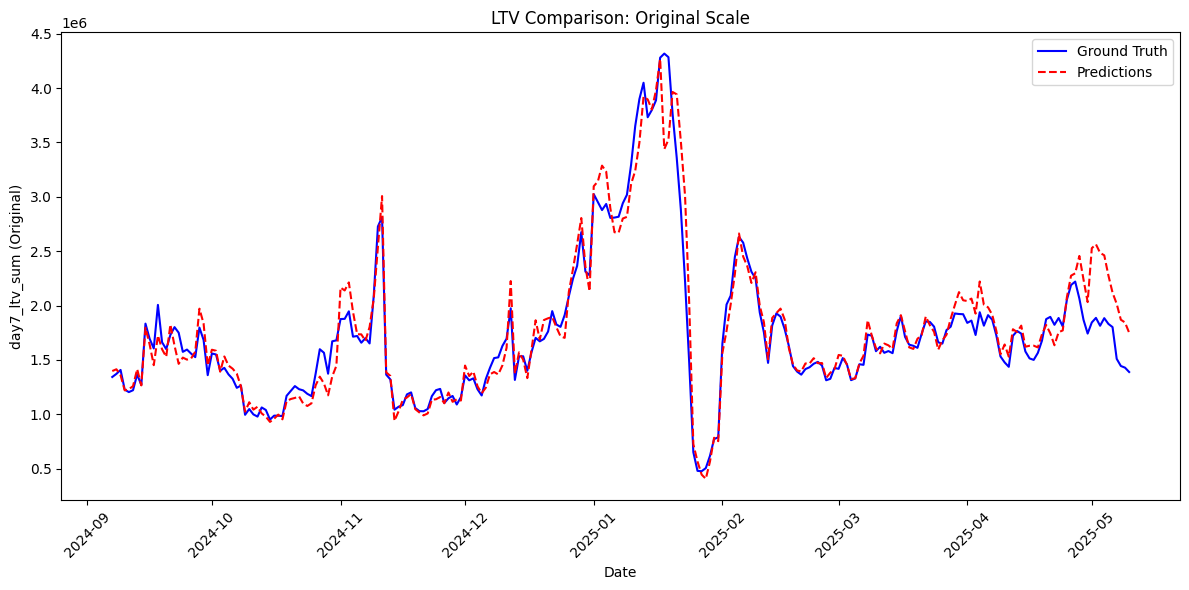

In [33]:
# 预测结果还原
with torch.no_grad():
    X_test_cat_tensor = torch.tensor(X_test[:, :len(categorical_features)], dtype=torch.long)
    X_test_dense_tensor = torch.tensor(X_test[:, len(categorical_features):], dtype=torch.float32)
    y_pred_tensor = model(X_test_cat_tensor, X_test_dense_tensor)
    y_pred_scaled = y_pred_tensor.squeeze().numpy()
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()  # 反标准化

# 测试集真实值还原
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# 评估指标计算（原始量纲）
mse_original = mean_squared_error(y_test_original, y_pred_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)
print(f"MSE(Original Scale): {mse_original:.2f}")
print(f"MAE(Original Scale): {mae_original:.2f}")

# 绘制真实值对比图（使用原始值）
plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_original, label='Ground Truth', color='blue')
plt.plot(test_dates, y_pred_original, label='Predictions', color='red', linestyle='--')
plt.title('LTV Comparison: Original Scale')
plt.xlabel('Date')
plt.ylabel('day7_ltv_sum (Original)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


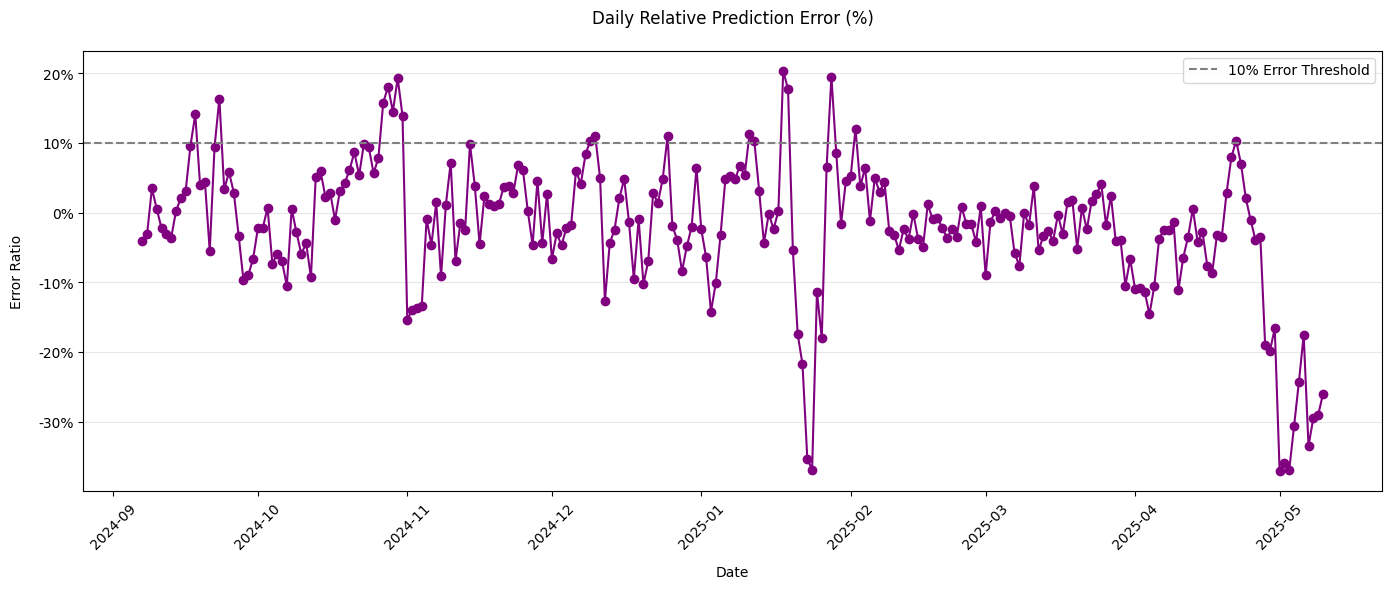

In [34]:
# 计算每日相对误差
relative_error = (y_test_original - y_pred_original) / y_test_original

# 创建日期索引的DataFrame便于聚合
error_df = pd.DataFrame({
    'date': test_dates,
    'error': relative_error
})

# 按天计算平均相对误差
daily_error = error_df.groupby('date').mean()

# 可视化设置
plt.figure(figsize=(14,6))
plt.plot(daily_error.index, daily_error['error'], 
         marker='o', linestyle='-', color='purple')
plt.axhline(y=0.1, color='gray', linestyle='--', 
           label='10% Error Threshold')

# 图表美化
plt.title('Daily Relative Prediction Error (%)', pad=20)
plt.xlabel('Date', labelpad=10)
plt.ylabel('Error Ratio', labelpad=10)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()

# 自动调整y轴显示为百分比格式
ax = plt.gca()
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

plt.show()
